In [286]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import os
import twint
import nest_asyncio

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from string import ascii_letters, digits
from textblob import TextBlob
from datetime import timedelta, date
from glob import glob
from wordcloud import WordCloud

#required to use twint!
nest_asyncio.apply()

#get path to project directory
DATA_DIR = os.path.join(
    os.path.dirname(os.path.realpath("__file__"))
)

TWEET_FILE = os.path.join(DATA_DIR, "test_tweets.csv")
TODAY = date.today().strftime("%Y-%m-%d")

In [2]:
#turns URL into clickable link
def make_clickable(val):
    return f'<a target="_blank" href="{val}">Tweet</a>'

#makes sure directory name is nice
def clean_name(dirname):
    valid = set(ascii_letters + digits)
    return ''.join(a for a in dirname if a in valid)

#performs twitter scrape
def twint_search(keyword, since, until, filename):
    c             = twint.Config()
    c.Search      = keyword
    c.Since       = since
    # c.Until       = until
    c.Lang        = "en"
    c.Filter_retweets = True
    c.Count       = True
    c.Pandas      = True
    c.Store_csv   = True
    c.Hide_output = True    
    c.Output      = filename

    try:
        twint.run.Search(c)    
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print(f"Problem with {since}.")
        
#loops through daterange to "break up" large scrapes
def twint_loop(keyword, since, until=TODAY):
    #name directory after keyword (search term)
    dirname = clean_name(keyword)
    
    try:
        #create target directory
        os.mkdir(dirname)
        print("Directory" , dirname ,  "created!")
    except FileExistsError:
        print("Directory" , dirname ,  "already exists!")
    
    daterange = pd.date_range(since, until)
    
    #goes one day at a time
    for start_date in daterange:
        since = start_date.strftime("%Y-%m-%d")
        until = (start_date + timedelta(days=1)).strftime("%Y-%m-%d")
        
        csv_name = f'{since}.csv'
        csv_name = os.path.join(DATA_DIR, dirname, csv_name)
        
        print(f'Scraping tweets on {since}...')
        twint_search(keyword, since, until, csv_name)
    
    #list out files
    result_files = os.listdir(dirname)
    print(f'\nPRODUCED {len(result_files)} FILES:')
    for file in result_files:
        print(f' - {file}')
        
    #returns combined (unfiltered) dataframe
    return combine_files(dirname)
        
def combine_files(dirname):
    #gather and concat all generated *.csv files
    file_names = glob(os.path.join(dirname,'*.csv'))
    dfs = [pd.read_csv(fn) for fn in file_names]
    df = pd.DataFrame()
    
    print('\nCOMBINING INTO DATAFRAME...')
    for scrape in dfs:
        df = pd.concat([df, scrape])
    print('...DONE!')
    
    return df

def basic_info(df):
    print(f'SHAPE BEFORE DUPLICATE REMOVAL: {df.shape}')
    data = df[['date', 'time', 'username', 'tweet', 'hashtags', 'link']].copy()
    data = data.drop_duplicates(['tweet']) #remove duplicates
    print(f'SHAPE AFTER DUPLICATE REMOVAL: {data.shape}\n')

    print(f'{data.info()}\n')
    data.head(5).style.format({'link': make_clickable}).set_properties(subset=['tweet', 'hashtags'], **{'width': '300px'})
    return data

In [3]:
ActivisionBlizz_df = twint_loop("\"Activision Blizzard\" OR Blizzard OR #blizzard OR \"Diversity Space Tool\"", "2022-05-09")

Directory ActivisionBlizzardORBlizzardORblizzardORDiversitySpaceTool created!
Scraping tweets on 2022-05-09...
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 37357 Tweets.
Scraping tweets on 2022-05-10...
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 33887 Tweets.
Scraping tweets on 2022-05-11...
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 30086 Tweets.
Scraping tweets on 2022-05-12...
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 26395 Tweets.
Scraping tweets on 2022-05-13...
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 22657 Tweets.
Scraping tweets on 2022-05-14...
[!] No more data! Scraping will stop now.
found 0 deleted tweets

C:\Users\admin\AppData\Local\Temp\ipykernel_33760\1229073416.py:68: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(fn) for fn in file_names]



COMBINING INTO DATAFRAME...
...DONE!


In [262]:
ActivisionBlizz_data = basic_info(ActivisionBlizz_df)

SHAPE BEFORE DUPLICATE REMOVAL: (179610, 36)
SHAPE AFTER DUPLICATE REMOVAL: (35893, 6)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35893 entries, 0 to 8
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      35893 non-null  object
 1   time      35893 non-null  object
 2   username  35893 non-null  object
 3   tweet     35893 non-null  object
 4   hashtags  35893 non-null  object
 5   link      35893 non-null  object
dtypes: object(6)
memory usage: 1.9+ MB
None



In [263]:
ActivisionBlizz_data['date'].value_counts()

2022-05-13    6505
2022-05-14    4808
2022-05-12    3762
2022-05-09    3760
2022-05-11    3707
2022-05-16    3677
2022-05-15    3581
2022-05-10    3480
2022-05-17    2613
Name: date, dtype: int64

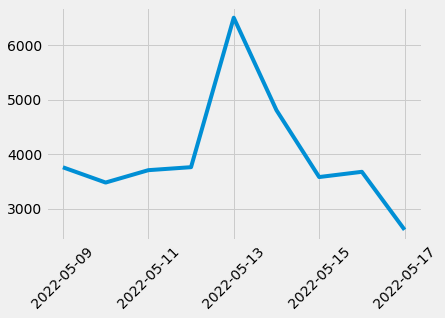

In [264]:
ActivisionBlizz_data['date'].value_counts().sort_index().plot()
plt.xticks(rotation=45)
plt.show()

In [265]:
def cleanTweets(text):
    text = re.sub(r'@[A-Za-z0–9]+','', text) #remove mentions
    text = re.sub(r'[#_\']','', text) #remove the #, _, and single quotation
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub(r'RT[\s]+','', text) #remove the RT
    text = re.sub(r'https?:\/\/\S+','', text) #remove hyperlink
    return text
                  
# apply the function
ActivisionBlizz_data['tweet'] = ActivisionBlizz_data['tweet'].apply(cleanTweets)
ActivisionBlizz_data.head()

,date,time,username,tweet,hashtags,link
0,2022-05-17,15:11:55,jameswe42087922,Bitcoin King USA Its Perfect Europe Asia Sout...,"['bitcoin', 'king', 'usa', 'europe', 'asia', '...",https://twitter.com/JamesWe42087922/status/152...
1,2022-05-17,15:11:12,g33kxinc,Blizzard will show off more ‘Overwatch ’ on Ju...,[],https://twitter.com/G33KXINC/status/1526686800...
2,2022-05-17,15:10:39,marsmews,"blizzard saw you on junkrat bro, this your f...",[],https://twitter.com/MarsMews/status/1526686662...
3,2022-05-17,15:10:18,ph0sphenes_,"Ok now they done goofed up, what the frick bli...",[],https://twitter.com/Ph0sphenes_/status/1526686...
4,2022-05-17,15:09:58,snwflkblizzard,Probably,[],https://twitter.com/SnwflkBlizzard/status/1526...


In [266]:
st = nltk.PorterStemmer()
lm = nltk.WordNetLemmatizer()
tk = RegexpTokenizer('\w+')

def remove_stopwords(data):
    text = [word for word in data if not word.lower() in stopwords.words('english')]
    return text

def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text

def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def list_to_string(text):
    return ' '.join(text)

def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [267]:
ActivisionBlizz_data['tweet'] = (ActivisionBlizz_data['tweet'].apply(tk.tokenize)
                                 .apply(lambda x: remove_stopwords(x))
                                 .apply(lambda x: stemming_on_text(x))
                                 .apply(lambda x: lemmatizer_on_text(x))
                                 .apply(list_to_string))

In [268]:
ActivisionBlizz_data.head()

,date,time,username,tweet,hashtags,link
0,2022-05-17,15:11:55,jameswe42087922,bitcoin king usa perfect europ asia southameri...,"['bitcoin', 'king', 'usa', 'europe', 'asia', '...",https://twitter.com/JamesWe42087922/status/152...
1,2022-05-17,15:11:12,g33kxinc,blizzard show overwatch june th,[],https://twitter.com/G33KXINC/status/1526686800...
2,2022-05-17,15:10:39,marsmews,blizzard saw junkrat bro fault,[],https://twitter.com/MarsMews/status/1526686662...
3,2022-05-17,15:10:18,ph0sphenes_,ok done goof frick blizzard,[],https://twitter.com/Ph0sphenes_/status/1526686...
4,2022-05-17,15:09:58,snwflkblizzard,probabl,[],https://twitter.com/SnwflkBlizzard/status/1526...


In [278]:
ActivisionBlizz_data['subjectivity'] = ActivisionBlizz_data['tweet'].apply(get_subjectivity)
ActivisionBlizz_data['polarity'] = ActivisionBlizz_data['tweet'].apply(get_polarity)
ActivisionBlizz_data['analysis'] = ActivisionBlizz_data['polarity'].apply(get_analysis)
sentiment_df = ActivisionBlizz_data[['date', 'time', 'tweet', 'subjectivity', 'polarity', 'analysis']].copy()
sentiment_df.head()

,date,time,tweet,subjectivity,polarity,analysis
0,2022-05-17,15:11:55,bitcoin king usa perfect europ asia southameri...,1.0,1.0,Positive
1,2022-05-17,15:11:12,blizzard show overwatch june th,0.0,0.0,Neutral
2,2022-05-17,15:10:39,blizzard saw junkrat bro fault,0.0,0.0,Neutral
3,2022-05-17,15:10:18,ok done goof frick blizzard,0.5,0.5,Positive
4,2022-05-17,15:09:58,probabl,0.0,0.0,Neutral


In [281]:
sentiment_df['time'] = pd.to_datetime(sentiment_df['time'])
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

In [300]:
sentiment_df.groupby('date').mean()

,subjectivity,polarity
date,,
2022-05-09,0.225990,0.025603
2022-05-10,0.214778,0.032800
2022-05-11,0.227141,0.031748
2022-05-12,0.209745,0.032199
2022-05-13,0.277943,0.010276
2022-05-14,0.247723,0.009027
2022-05-15,0.211908,0.022362
2022-05-16,0.197122,0.019630
2022-05-17,0.208812,0.017685


In [285]:
# sentiment_df.iloc[:,1].dt.hour

0    15
1    15
2    15
3    15
4    15
     ..
4    16
5    16
6    16
7    16
8    16
Name: time, Length: 35893, dtype: int64